In [3]:
import Pkg;
Pkg.add("StaticArrays")
Pkg.add("BenchmarkTools")
Pkg.add("Plots")
Pkg.add("CUDA")
Pkg.add("LinearAlgebra")
Pkg.add("Adapt")
Pkg.add("StatsPlots")
Pkg.add("BenchmarkPlots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Qt5Base_jll ─ v5.15.3+1
  No Changes to `~/.julia/environments/v1.7/Project.toml`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [ea2cea3b] ↑ Qt5Base_jll v5.15.3+0 ⇒ v5.15.3+1
Precompiling project...
  ✓ Qt5Base_jll
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  ✓ StatsPlots
  5 dependencies successfully precompiled in 85 seconds (170 already precompiled)
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [91a5bcdd] + Plots v1.27.6
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environ

In [6]:
using StaticArrays
using BenchmarkTools
using LinearAlgebra
using CUDA
using Adapt
#using Cthulhu
using StatsPlots
using BenchmarkPlots
using Profile
include("photon_prob_cuda.jl")

"suite = BenchmarkGroup()\n\nnphs = trunc.(Int, 10 .^ (range(1, 7.5, length=10)))\n\nfor nph in nphs\n    suite[nph] = make_bench_cuda_step_photons!(nph)\nend\n\nresults = run(suite, verbose=true)\nmed_time_per_ph = Dict(key => val.time / key for (key, val) in median(results))\nprint(med_time_per_ph)\nplot(med_time_per_ph, yscale=:log10, ylabel=\"Time / photon\", xlabel=\"Photons\", ylims=(0.1, 1E3), xscale=:log10)\n\n#test()\n"

N: 10, threads: 10, blocks: 1
N: 21, threads: 21, blocks: 1
N: 48, threads: 48, blocks: 1
N: 106, threads: 106, blocks: 1
N: 233, threads: 233, blocks: 1
N: 513, threads: 513, blocks: 1
N: 1128, threads: 1024, blocks: 2
N: 2481, threads: 1024, blocks: 3
N: 5455, threads: 1024, blocks: 6
N: 11993, threads: 1024, blocks: 12
N: 26366, threads: 1024, blocks: 26
N: 57963, threads: 1024, blocks: 57
N: 127427, threads: 1024, blocks: 125
N: 280135, threads: 1024, blocks: 274
N: 615848, threads: 1024, blocks: 602
N: 1353876, threads: 1024, blocks: 1323
N: 2976351, threads: 1024, blocks: 2907
N: 6543189, threads: 1024, blocks: 6390
N: 14384498, threads: 1024, blocks: 14048
N: 31622776, threads: 1024, blocks: 30882
(1/20) benchmarking 5455...
done (took 6.179368511 seconds)
(2/20) benchmarking 6543189...
done (took 7.460500929 seconds)
(3/20) benchmarking 1353876...
done (took 7.540922359 seconds)
(4/20) benchmarking 2976351...
done (took 7.347766767 seconds)
(5/20) benchmarking 14384498...
done 

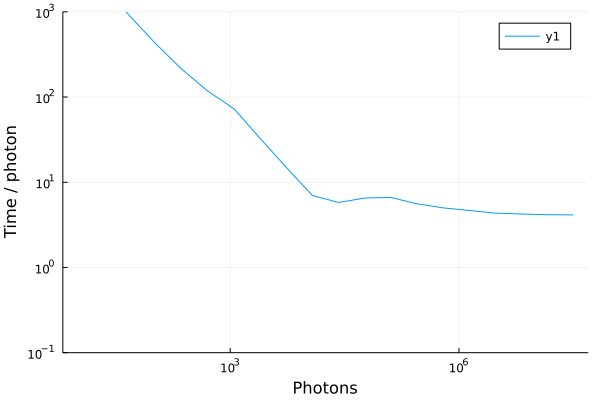

In [2]:
suite = BenchmarkGroup()

nphs = trunc.(Int, 10 .^ (range(1, 7.5, length=20)))
#nphs = [10]

for nph in nphs
    suite[nph] = make_bench_cuda_step_photons!(nph)
end

results = run(suite, verbose=true)
med_time_per_ph = Dict(key => val.time / key for (key, val) in median(results))
print(med_time_per_ph)
plot(med_time_per_ph, yscale=:log10, ylabel="Time / photon", xlabel="Photons", ylims=(0.1, 1E3), xscale=:log10)

In [21]:
struct PhotonTarget{T<:Real}
    position::SVector{3,T}
    radius::T
end
abstract type Spectrum end

struct Monochromatic{T} <: Spectrum
    wavelength::T
end

abstract type EmissionProfile end
struct Isotropic{T} <: EmissionProfile end

struct PhotonSource{T, U<:Spectrum, V<:EmissionProfile}
    position::SVector{3,T}
    time::T
    photons::Int64
    spectrum::U
    emission_profile::V
end

function initialize_direction_isotropic(T::Type)
    theta = uniform(T(-1), T(1))
    phi = uniform(T(0), T(2 * pi))
    sph_to_cart(theta, phi)
end

initialize_direction(::T) where T <: EmissionProfile = throw(ArgumentError("Cannot initialize $T"))
initialize_direction(::Isotropic{T}) where T  = initialize_direction_isotropic(T)

initialize_wavelength(::T) where T <: Spectrum = throw(ArgumentError("Cannot initialize $T"))
initialize_wavelength(spectrum::Monochromatic{T}) where T = spectrum.wavelength




function initialize_photons!(source::PhotonSource{T, U, V}, photon_container::AbstractMatrix{T}) where {T, U, V}
    for i in 1:source.photons
        photon_container[1:3, i] = source.position
        photon_container[4:6, i] = initialize_direction(source.emission_profile)
        photon_container[7, i] = T(0)
        photon_container[8, i] = initialize_wavelength(source.spectrum)
    end
   
    return photons
end



initialize_photons (generic function with 1 method)

In [22]:
source = PhotonSource(@SVector[0f0 ,0f0, 0f0], 0f0, 100, Monochromatic(450f0), Isotropic{Float32}())
initialize_photons(source)

8×100 Matrix{Float32}:
   0.0         0.0         0.0          0.0       …    0.0          0.0
   0.0         0.0         0.0          0.0            0.0          0.0
   0.0         0.0         0.0          0.0            0.0          0.0
  -0.563563    0.223424    0.0242749   -0.554285       0.0031155   -0.547836
   0.462711   -0.697391    0.013322     0.215398       0.703527     0.537545
   0.684321    0.680975    0.999617     0.803973  …    0.710662     0.641031
   0.0         0.0         0.0          0.0            0.0          0.0
 450.0       450.0       450.0        450.0          450.0        450.0

2016858445

In [44]:
get_total_photons(sources::AbstractVector{PhotonSource{T, U, V}}) where {T, U, V} = sum(getproperty.(sources, :photons))


scattering_coeff(wavelength) = 1/20f0

function launch_kernel(pos, dir, dist_travelled, sca_coeffs, intersected, target, steps, seed)
    kernel = @cuda launch = false cuda_step_photons!(
        pos,
        dir,
        dist_travelled,
        sca_coeffs,
        intersected,
        Val(target),
        Val(steps),
        seed)
    config = launch_configuration(kernel.fun, shmem=calc_shmem)
    threads = min(N, config.threads)
    blocks = cld(N, threads)
    shmem = calc_shmem(threads)
    kernel(
        pos, dir, dist_travelled, sca_coeffs, intersected, Val(target), Val(steps), seed, threads=threads, blocks=blocks, shmem=shmem)
end

function prepare_and_launch_kernel(photons_step::AbstractMatrix{T}, target::PhotonTarget{T}, steps::UInt16) where T
    length = size(photons_step, 2)
    positions = CuMatrix(photons_step[1:3, :])
    directions = CuMatrix(photons_step[4:6, :])
    times = CuVector{T}(photons_step[7, :])
    sca_coeffs = CuVector{T}(scattering_coeff.(photons_step[8, :]))
    dist_travelled = CuVector(zeros(T, length))
    intersected = CuVector(zeros(Bool, length))

    # Seeding might be dangerous 
    launch_kernel(positions, directions, dist_travelled, sca_coeffs, intersected, Val(target), Val(steps), rand(UInt32))
end


function propagate_sources(sources::AbstractVector{PhotonSource{T, U, V}}) where {T, U, V}
    total_photons = get_total_photons(sources)
    max_photons = 2^25
    n_photons_step = min(max_photons, total_photons)

    n_steps = ceil(Int64, total_photons / max_photons)
    photons_step = Matrix{T}(undef, 8, n_photons_step)
    target_pos = @SVector [0.0f0, 0.0f0, 5.0f0]
    target = PhotonTarget(target_pos, 1.0f0)

    initial_seed = 0

    prop_steps = UInt16(10)

    photons_queued = 0
    for source in sources
        println("Photons queued: $photons_queued")
        if photons_queued + source.photons >= n_photons_step
            println("Queuing kernel: $photons_queued")
            prepare_and_launch_kernel(photons_step[:, 1:photons_queued], target, prop_steps)
            photons_queued = 0
        end
        println("Space in buffer: $photons_queued")
        initialize_photons!(source, view(photons_step, :, photons_queued+1:photons_queued+1+source.photons))
    end
    prepare_and_launch_kernel(photons_step[:, :photons_queued], target, prop_steps)
end




Photons queued: 0
Queuing kernel: 0


propagate_sources (generic function with 2 methods)

In [45]:
propagate_sources([source])

GPUCompiler.KernelError: GPU compilation of kernel cuda_step_photons!(CuDeviceMatrix{Float32, 1}, CuDeviceMatrix{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Bool, 1}, Val{Val{PhotonTarget{Float32}(Float32[0.0, 0.0, 5.0], 1.0f0)}()}, Val{Val{0x000a}()}, UInt32) failed
KernelError: kernel returns a value of type `Union{}`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


In [ ]:

"""   


sca_len = 10.0f0

photons = initialize_photons(N, Float32, (T) -> [0.0f0, 0.0f0, 0.0f0], initialize_direction_isotropic, (T) -> 1 / 20.0f0)
intersected = CuArray(zeros(Bool, N))

steps = UInt16(10)
seed = UInt32(1)

pos = CuArray(photons[1:3, :])
dir = CuArray(photons[4:6, :])
dist_travelled = CuArray(photons[7, :])
sca_coeffs = CuArray(photons[8, :])

kernel = @cuda launch = false cuda_step_photons!(
    pos,
    dir,
    dist_travelled,
    sca_coeffs,
    intersected,
    Val(target),
    Val(steps),
    seed)
config = launch_configuration(kernel.fun, shmem=calc_shmem)
threads = min(N, config.threads)
blocks = cld(N, threads)
println("N: $N, threads: $threads, blocks: $blocks")
shmem = calc_shmem(threads)
bench = @benchmarkable CUDA.@sync $kernel(
    $pos, $dir, $dist_travelled, $sca_coeffs, $intersected, $(Val(target)), $(Val(steps)), $seed, threads=$threads, blocks=$blocks, shmem=$shmem)
CUDA.reclaim()
"""

In [3]:
photons[:, 1]

UndefVarError: UndefVarError: photons not defined

In [28]:
target_pos = @SVector [0.0f0, 0.0f0, 5.0f0]
target = PhotonTarget(target_pos, 1.0f0)

N = 15
positions = zeros(Float32, 3, N)
dirs = Matrix{Float32}(undef, 3, N)
for i in 1:N
    dirs[:, i] = [0f0, 0f0, 1f0] # initialize_direction_isotropic(Float32)
end

sca_len = 20f0

photon_config = PhotonConfig(target, 1 / sca_len, 1.0f0)
#pos, dir, intersected, dist_travelled = generate_inputs(N)
steps = UInt16(10)

intersected = zeros(Bool, N)
dist_travelled = zeros(Float32, N)

pos, dirs, intersected, dist_travelled = CuArray(positions), CuArray(dirs), CuArray(intersected), CuArray(dist_travelled)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 1.0 1.0 … 1.0 1.0], Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [29]:
all_pos = propagate(pos, dirs, intersected, dist_travelled, photon_config, UInt16(10), UInt32(1))

1
2
3
4
5
6
7
8
9
10


3×15×11 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
  13.7892   -14.1102   34.2927   -1.84489  …    3.89622   -5.08057   -6.66743
  -9.75301   -7.2169   37.3106    1.22802      -7.75641   -4.17987   -5.91603
 105.756    238.778   170.645   205.378       188.741    258.894    209.77

[:, :, 3] =
  13.3008  -12.7923    33.1251  …   -1.7277    -7.20304   -4.83589
 -11.37     -8.27534   39.503       -9.11382   -3.07668   -8.7271
 296.079   399.073    348.876      380.616    427.474    442.949

;;; … 

[:, :, 9] =
    0.401277   244.014    38.2157  …   -35.5584      1.85045    -6.52436
   -9.12883   -302.028    39.5196       -1.95264    -4.848      -9.46126
 1519.76      1471.29   1344.51       1729.21     1632.13     1382.37

[:, :, 10] =
    8.02405   235.627    41.15

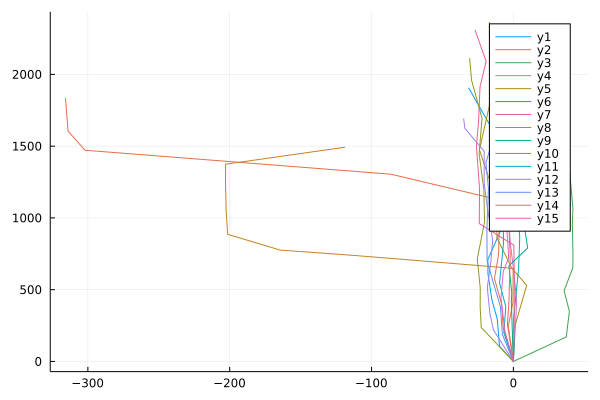

In [33]:
plot(all_pos[2,:,:]', all_pos[3, :, :]')

In [2]:
struct Medium
    scattering_function::Function
    scattering_length::Function
    absorption_length::Function
end

function sca_len_part(wavelength, vol_conc_small_part, vol_conc_large_part)
    """
    Make a function that calculates the scattering length based on particle concentrations.
    Copied from clsim.

    Parameters:
        vol_conc_small_part: Volumetric concentration of small particles (ppm)
        vol_conc_large_part: Volumetric concentration of large particles (ppm)

    """
    ref_wlen = 550  # nm
    x = ref_wlen / wavelength

    sca_coeff = (
        0.0017 * x^4.3
        + 1.34 * vol_conc_small_part * x^1.7
        + 0.312 * vol_conc_large_part * x^0.3
    )

    return 1 / sca_coeff
end

cascadia_sca_len = wavelength -> sca_len_part(wavelength, 0.0075, 0.0075)



#9 (generic function with 1 method)

In [4]:
CUDA.clamp

clamp (generic function with 6 methods)

In [3]:
mutable struct Photon{T<:Real}
    position::SVector{3, T}
    direction::SVector{3, T}
    dist_travelled::T
    wavelength::T
    #scattering_length::T
    #group_velocity::T
    #phase_velocity::T
    steps::Int
    intersected::Bool
end
Adapt.@adapt_structure Photon

function rotate_to_new_direc(old_dir::SVector{3, T}, new_dir::SVector{3, T}, operand::SVector{3, T}) where T
    
    if old_dir == new_dir
        return operand
    end
    
    axis = cross(old_dir, new_dir)
    axis /= norm(axis)

    theta = acos(dot(old_dir, new_dir))

    # Rodrigues' rotation formula

    v_rot = (
        operand * cos(theta)
        + cross(axis, operand) * sin(theta)
        + axis
        * dot(axis, operand)
        * (1 - cos(theta))
    )
end

struct IntersectionResult{T<:Real}
    intersected::Bool
    position::Union{Nothing, AbstractArray{T, 1}}
end

struct PhotonTarget{T<:Real}
    position::AbstractArray{T, 1}
    radius::T
end

function photon_sphere_intersection(photon::Photon, photon_target::PhotonTarget{T}, step_size::T) where T
    """
    Calculate intersection.

    Given a photon origin, a photon direction, a step size, a target location and a target radius,
    calculate whether the photon intersects the target and the intrsection point.
    """
    p_normed = photon.direction   # assume normed
    photon_pos = photon.position
    target_pos = target.position
    target_r = target.radius

    a = dot(p_normed, (photon_pos - target_pos))
    b = a^2 - (norm(photon_pos - target_pos) ^ 2 - target_r^2)
    if b < 0
        return IntersectionResult{T}(false, nothing)
    end
    # Distance of of the intersection point along the line
    d = -a - sqrt(b)

    isected = (b >= 0) & (d > 0) & (d < step_size)

    if isected
        return IntersectionResult(true, photon_pos + d * p_normed)

    else
        return IntersectionResult{T}(false, nothing)
    end
end


   
function scattering_func(g::T) where T
    """Henyey-Greenstein scattering in one plane."""
    eta = T(rand(Uniform{T}(T(0), T(1))))
    costheta = (1 / (2 * g) * (1 + g^2 - ((1 - g^2) / (1 + g * (2 * eta - 1))) ^ 2))

    acos(clamp(costheta, T(-1), T(1)))
end

function move_photon!(photon::Photon{T}, target::PhotonTarget{T}, step_size::T) where T

    isec = photon_sphere_intersection(photon, target, step_size)

    if isec.intersected
        photon.dist_travelled += norm(isec.position - photon.position)
        photon.position = isec.position
        photon.intersected = true
        return nothing
    end
            

    photon.position = photon.position + photon.direction * step_size
    photon.dist_travelled += step_size

    sca_theta = scattering_func(T(0.97))
    sca_phi = T(rand(Uniform{T}(T(0), T(2*pi))))
    dir_cart = sph_to_cart(sca_theta, sca_phi)
    e_z = @SVector[0, 0, T(1)]
    photon.direction = rotate_to_new_direc(e_z, photon.direction, dir_cart)
    nothing
end

function move_photons!(photons::AbstractVector{Photon{T}}, target::PhotonTarget{T}, step_size::T) where T
    @. move_photon!(photon, target, step_size)
    """
    for photon in photons
        move_photon!(photon, target, step_size)
    end
    """
    nothing
end

function photon_step!(photon::Photon{T}, target::PhotonTarget{T}, sca_len::T) where T
    step_size = T(rand(Exponential(sca_len)))
    move_photon!(photon, target, step_size)
    nothing
end

function do_steps(photon::Photon{T}, target::PhotonTarget{T}, sca_len::T, steps::Int) where T
    positions = SVector{3, T}[]
    for _ in 1:steps
        photon_step!(photon, target, sca_len)
        push!(positions, photon.position)
    end
    positions
end

function sph_to_cart(theta::T, phi::T) where T
    x::T = cos(phi) * sin(theta)
    y::T = sin(phi) * sin(theta)
    z::T = cos(theta)
    @SVector[x, y, z]
    #CuArray([x, y, z])
end

function initialize_direction_isotropic(T::Type)
    theta = T(rand(Uniform(-1., 1)))
    phi = T(rand(Uniform(0, 2*pi)))
    sph_to_cart(theta, phi)
end

function make_photons(num::Int, T::Type)
    pos = @SVector[T(0.), 0, 0]
    #pos = CuArray(zeros(T, 3))
    dist_travelled = T(0)
    wavelength = T(200)
    steps = 0
    intersected = false
    [Photon(pos, initialize_direction_isotropic(T), dist_travelled, wavelength, steps, intersected) for i in 1:num]

end



make_photons (generic function with 1 method)

In [6]:
photons = make_photons(Int64(1E6), Float32);

In [5]:
photons = make_photons(Int64(1E6), Float32)
target = PhotonTarget(@SVector[1f0, 0, 0], 0.21f0)
@benchmark positions = do_steps.(photons, [target], 20f0, 10)


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.611 s (15.74% GC) to evaluate,
 with a memory estimate of 4.02 GiB, over 164000029 allocations.

In [7]:
@profile photon_step!.(photons, [target], 20f0)

1000000-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [9]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function


   ╎1367 @Base/client.jl:506; _start()
   ╎ 1367 @Base/client.jl:296; exec_options(::Base.JLOptions)
   ╎  1367 @Base/Base.jl:368; include(::Module, ::String)
   ╎   1367 @Base/Base.jl:380; include(::Function, ::Module, ...
   ╎    1367 ...otebook/notebook.jl:32; top-level scope
   ╎     1367 .../serve_notebook.jl:75; (::VSCodeServer.var"#serve_no...


   ╎    ╎ 1367 ...serve_notebook.jl:136; serve_notebook(::String, ::B...
   ╎    ╎  1367 ...NRPC/src/typed.jl:67; dispatch_msg(::VSCodeServer....
   ╎    ╎   1367 ...serve_notebook.jl:13; notebook_runcell_request(::...
   ╎    ╎    1367 ...rver/src/repl.jl:184; withpath(::VSCodeServer.va...
   ╎    ╎     1367 ...erve_notebook.jl:19; (::VSCodeServer.var"#160#1...
   ╎    ╎    ╎ 1367 ...e/essentials.jl:709; invokelatest
   ╎    ╎    ╎  1367 ...e/essentials.jl:710; #invokelatest#1
 27╎    ╎    ╎   1367 @Base/loading.jl:1091; include_string(::Functi...
   ╎    ╎    ╎    5    ...e/broadcast.jl:1263; broadcasted(::Function...
  3╎    ╎    ╎     5    .../broadcast.jl:1265; broadcasted
   ╎    ╎    ╎    ╎ 2    .../typeinfer.jl:601; typeinf_ext(::Core.Met...
   ╎    ╎    ╎    ╎  2    .../typeinfer.jl:570; typeinf_ext(::Core.Me...
   ╎    ╎    ╎    ╎   2    .../typeinfer.jl:12; typeinf(::Core.Compil...
   ╎    ╎    ╎    ╎    2    ...pretation.jl:1326; typeinf_nocycle(::C...
   ╎    ╎    ╎    ╎  

  2╎    ╎    ╎    ╎    ╎    ╎     2    .../float.jl:402; -
   ╎    ╎    ╎    ╎    ╎    ╎ 1    ...linalg.jl:205; dot(::SArray{Tup...
   ╎    ╎    ╎    ╎    ╎    ╎  1    ...linalg.jl:218; _vecdot
   ╎    ╎    ╎    ╎    ╎    ╎   1    ...mdloop.jl:77; macro expansion
   ╎    ╎    ╎    ╎    ╎    ╎    1    ...linalg.jl:219; macro expansion
   ╎    ╎    ╎    ╎    ╎    ╎     1    ...eneric.jl:884; dot
  1╎    ╎    ╎    ╎    ╎    ╎    ╎ 1    .../float.jl:404; *
453╎    ╎    ╎    ╎    ╎     455  ...prob.ipynb:59; photon_sphere_in...
  1╎    ╎    ╎    ╎    ╎    ╎ 1    ...tfuncs.jl:296; literal_pow(::ty...
  1╎    ╎    ╎    ╎    ╎    ╎ 1    ...linalg.jl:16; -(::SArray{Tuple...
 53╎    ╎    ╎    ╎    ╎     55   ...prob.ipynb:60; photon_sphere_in...
  1╎    ╎    ╎    ╎    ╎    ╎ 2    .../float.jl:503; <(::Float32, ::I...
  1╎    ╎    ╎    ╎    ╎    ╎  1    ...e/bool.jl:40; &
 17╎    ╎    ╎    ╎    ╎     17   ...prob.ipynb:61; photon_sphere_in...
   ╎    ╎    ╎    ╎    ╎    47   ...prob.ipynb:90; mov

   ╎    ╎    ╎    ╎    ╎    ╎   2    ...l/trig.jl:91; sin_kernel
  2╎    ╎    ╎    ╎    ╎    ╎    2    .../float.jl:405; *
   ╎    ╎    ╎    ╎    ╎    ╎   2    ...l/trig.jl:94; sin_kernel
  1╎    ╎    ╎    ╎    ╎    ╎    1    .../float.jl:405; *
  1╎    ╎    ╎    ╎    ╎    ╎    1    .../float.jl:401; +
   ╎    ╎    ╎    ╎    ╎    ╎ 2    ...l/trig.jl:41; sin(::Float32)
  2╎    ╎    ╎    ╎    ╎    ╎  2    ...em_pio2.jl:0; rem_pio2_kernel
   ╎    ╎    ╎    ╎    ╎    ╎ 2    ...l/trig.jl:46; sin(::Float32)
   ╎    ╎    ╎    ╎    ╎    ╎  1    ...l/trig.jl:161; cos_kernel
   ╎    ╎    ╎    ╎    ╎    ╎   1    ...e/math.jl:122; evalpoly
   ╎    ╎    ╎    ╎    ╎    ╎    1    ...e/math.jl:123; macro expansion
  1╎    ╎    ╎    ╎    ╎    ╎     1    .../float.jl:410; muladd
   ╎    ╎    ╎    ╎    ╎    ╎  1    ...l/trig.jl:162; cos_kernel
  1╎    ╎    ╎    ╎    ╎    ╎   1    .../float.jl:405; *
   ╎    ╎    ╎    ╎    ╎     5    ...prob.ipynb:137; sph_to_cart(::Fl...
   ╎    ╎    ╎    ╎    ╎    ╎ 5  

   ╎    ╎    ╎    ╎    ╎    ╎  1    ...m_pio2.jl:287; rem_pio2_kernel
   ╎    ╎    ╎    ╎    ╎    ╎   1    ...number.jl:7; convert
  1╎    ╎    ╎    ╎    ╎    ╎    1    .../float.jl:255; Float64
   ╎    ╎    ╎    ╎    ╎    ╎  1    ...m_pio2.jl:290; rem_pio2_kernel
  1╎    ╎    ╎    ╎    ╎    ╎   1    .../float.jl:460; <=
   ╎    ╎    ╎    ╎    ╎    ╎ 1    ...l/trig.jl:46; sin(::Float32)
   ╎    ╎    ╎    ╎    ╎    ╎  1    ...l/trig.jl:161; cos_kernel
   ╎    ╎    ╎    ╎    ╎    ╎   1    ...e/math.jl:122; evalpoly
   ╎    ╎    ╎    ╎    ╎    ╎    1    ...e/math.jl:123; macro expansion
  1╎    ╎    ╎    ╎    ╎    ╎     1    .../float.jl:410; muladd
   ╎    ╎    ╎    ╎    ╎    ╎ 4    ...linalg.jl:22; *
   ╎    ╎    ╎    ╎    ╎    ╎  4    ...reduce.jl:31; map
   ╎    ╎    ╎    ╎    ╎    ╎   4    ...reduce.jl:40; _map
   ╎    ╎    ╎    ╎    ╎    ╎    4    ...reduce.jl:75; macro expansion
   ╎    ╎    ╎    ╎    ╎    ╎     4    ...linalg.jl:22; #385
  4╎    ╎    ╎    ╎    ╎    ╎    ╎ 4    ...

   ╎    ╎    ╎    ╎    ╎    ╎    ╎   1    ...tation.jl:111; abstract_call_g...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    1    ...tation.jl:419; abstract_call_m...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎     1    ...einfer.jl:484; typeinf_edge(::...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 1    ...einfer.jl:12; typeinf(::Core....
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  1    ...tation.jl:1326; typeinf_nocycle...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎   1    ...tation.jl:1270; typeinf_local(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎    1    ...tation.jl:1005; abstract_eval(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎     1    ...tation.jl:911; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +1 1    ...tation.jl:926; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +2 1    ...tation.jl:904; abstract_call_k...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +3 1    ...tation.jl:111; abstract_call_g...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +4 1    ...tation.jl:419; abstract_call

   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +49 2    ...tation.jl:1005; abstract_eval(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +50 2    ...tation.jl:911; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +51 2    ...tation.jl:926; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +52 2    ...tation.jl:904; abstract_call_k...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +53 2    ...tation.jl:111; abstract_call_g...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +54 2    ...tation.jl:419; abstract_call_m...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +55 2    ...einfer.jl:484; typeinf_edge(::...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +56 2    ...einfer.jl:12; typeinf(::Core....
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +57 2    ...tation.jl:1326; typeinf_nocycle...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +58 2    ...tation.jl:1270; typeinf_local(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +59 2    ...tation.jl:1005; abstract_eval(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +60 2    ..

   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +42 1    ...einfer.jl:21; typeinf(::Core....
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +43 1    ...einfer.jl:149; finish
  1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +44 1    ...einfer.jl:291; type_annotate!(...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +8 5    ...tation.jl:1270; typeinf_local(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +9 5    ...tation.jl:1005; abstract_eval(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +10 5    ...tation.jl:911; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +11 5    ...tation.jl:926; abstract_call(:...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +12 5    ...tation.jl:904; abstract_call_k...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 4    ...tation.jl:111; abstract_call_g...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 4    ...tation.jl:419; abstract_call_m...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 4    ...einfer.jl:484; typeinf_edge(::...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 3    ...einfer.jl:12;

   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +8 1    ...driver.jl:149; run_passes(::Co...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +9 1    ...air/ir.jl:1296; compact!
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +10 1    ...air/ir.jl:1299; compact!(::Core...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +11 1    ...air/ir.jl:1285; finish
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +12 1    ...air/ir.jl:1258; simple_dce!(::C...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 1    .../array.jl:413; getindex
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 1    ...e/boot.jl:425; Array
  1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 1    ...e/boot.jl:406; Array
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +6 1    ...einfer.jl:67; typeinf(::Core....
  1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +7 1    ...einfer.jl:122; cache_result(::...
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 2    ...einfer.jl:33; typeinf(::Core....
   ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  2    ...timize.jl:174; optimize(::Core...
   ╎    ╎    ╎    ╎    ╎    ╎  

In [25]:
@benchmark $photon_step!.($photons, [$target], 20f0)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  518.989 ms … 588.850 ms  ┊ GC (min … max): 5.36% … 10.53%
 Time  (median):     539.773 ms               ┊ GC (median):    7.66%
 Time  (mean ± σ):   542.595 ms ±  19.655 ms  ┊ GC (mean ± σ):  7.81% ±  2.65%

  ▁   ▁     ▁  ▁  ▁  ▁   █        ▁                           ▁  
  █▁▁▁█▁▁▁▁▁█▁▁█▁▁█▁▁█▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  519 ms           Histogram: frequency by time          589 ms <

 Memory estimate: 366.21 MiB, allocs estimate: 16000018.

In [23]:
500E6 / 1E6

500.0

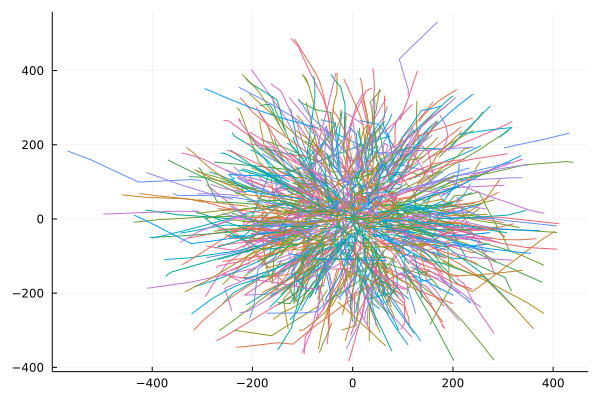

In [104]:
using Plots
x = cat([ cat(positions[i]..., dims=2)[1, :] for i in 1:1000]..., dims=2)
y = cat([ cat(positions[i]..., dims=2)[2, :] for i in 1:1000]..., dims=2)
plot(x, y, legend=false)

In [39]:
@btime $move_photon!.($photons, [1.])

  214.133 ms (2 allocations: 176 bytes)


1000000-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [28]:
@btime $move_photons!($photons, 1.)

  215.827 ms (0 allocations: 0 bytes)


In [2]:
215E6 / 1E6

215.0

In [10]:
@btime move_photon(a, 1.)

UndefVarError: UndefVarError: move_photon not defined

In [9]:
function test()
    a::Float32 = 1.2
    b::Float64 = 1.2

    print(typeof(a*b))
end


test (generic function with 1 method)

In [10]:
test()

Float64